<a href="https://colab.research.google.com/github/YorkU-Cameroon/ml_labs/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying to Understand Machine Learning for Regression


# Setup Code

## Imports
Do all the needed imports

In [ ]:
from datetime import datetime
import math
from random import random

import matplotlib.pyplot as plt
import numpy as np
from keras import layers, models
from tensorflow.keras.utils import to_categorical

## Define Global Variables

In [ ]:
AP = {}                      # Make "Attempt Parameters" a global variable 
trainX = np.zeros((60000,2)) # A list of lots of x = [x0,...,x_{n-1}] values chosen randomly
trainY = np.zeros(60000)     # The supervisors answers y=f(x)
testX  = np.zeros((10000,2)) # Same but for testing
testY  = np.zeros(10000)     #
network = 0                  # The learned neural network
custom_func = None           # Used to define a custom function for mapping an input x to a real value
meanX = meanY = 0
stdX = stdY = 1

## setAP - DEFAULT ATTEMPT PARAMETERS

In [ ]:
##########################################################
"""    
  setAP(APValues)                                        
    AP are "Attempt Parameters" (a global variable)      
    APValues specifies a list of parameters to set       
     eg setAP(["function","exp"],["degree",3])           
          sets function = "exp" and degree = 3           
          remaining parameters are set to their defaults 
"""  
##########################################################

def setAP(*APV):
  global AP 
  #     parameter name : default value
  AP = {"nDimensions":1,      # x = [x0,..,xn]
        "maxX":100,           # xi in [0..maxX]   
        "categorize":[],      # [] means the output is one real number
                              # [10,20,30] means 4 categories y=
                              # 0 if {yy<10}, 1 if {10<=yy<20}, ..., 3 if {30<=yy} 
        "nItemsTrain":384000, # num of training data
        "nItemsTest": 10000,  # num of testing data
        "function":"poly",    # vs "exp"
        "nGraphPoints":100,   # number points in graph
        "degree":2,           # x0^degree vs degree^x0
        "graph_r":0,          # graph wrt xr
        "graph_x":-1,         # graph with other values set as x = [maxX/2,...] 
        "logscale":False,     # if True, graph log(y)
        "noise":0,            # add noise to x and y
        "nLayers":2,          # num of layers in the neural network
        "nHidden":512,        # num of nodes in each hidden layer
        "activation":"relu",  # how each neuron is activated vs sigmoid
        "epochs":5,           # number of passes through data
        "batch":128,          # num items per hill climbing step
        "normalize":True ,    # If true normalization is done otherwise not done
        "optimizer":"rmsprop",# Optimizer to be used
        "graph_at_end":False ,# Controls if all graphs only show at end of cell 
                              # after cell completes execution otherwise they 
                              # are shown once they are ready
        "train_verbosity":1,  # 0 - Silent, 1 - Progress bar (see cell below)                              
      }  

  # Override values with values from parameter
  for APv in APV:    
    if AP.get(APv[0]) is None:
      raise Exception(f'Invalid Key for AP found: {APv[0]} in {APV}')
    AP[APv[0]] = APv[1]

  if AP['graph_x'] == -1:
    AP['graph_x'] = [AP['maxX']/2] * AP['nDimensions']

setAP()
print(AP)
setAP(["function","exp"],["degree",3])
print(AP)
print(AP["nDimensions"])
print(AP["function"])
if AP["function"]=="exp":
  print("excellent")

{'nDimensions': 1, 'maxX': 100, 'categorize': [], 'nItemsTrain': 384000, 'nItemsTest': 10000, 'function': 'poly', 'nGraphPoints': 100, 'degree': 2, 'graph_r': 0, 'graph_x': [50.0], 'logscale': False, 'noise': 0, 'nLayers': 2, 'nHidden': 512, 'activation': 'relu', 'epochs': 5, 'batch': 128, 'normalize': True, 'optimizer': 'rmsprop', 'graph_at_end': False, 'train_verbosity': 1}
{'nDimensions': 1, 'maxX': 100, 'categorize': [], 'nItemsTrain': 384000, 'nItemsTest': 10000, 'function': 'exp', 'nGraphPoints': 100, 'degree': 3, 'graph_r': 0, 'graph_x': [50.0], 'logscale': False, 'noise': 0, 'nLayers': 2, 'nHidden': 512, 'activation': 'relu', 'epochs': 5, 'batch': 128, 'normalize': True, 'optimizer': 'rmsprop', 'graph_at_end': False, 'train_verbosity': 1}
1
exp
excellent


### Additional Parameter Information
For more information on verbosity see [keras documentation](https://keras.io/api/models/model_training_apis/)



## Supporting Math Functions

### argmax

In [ ]:
def argmax(iterable):
  """
  Returns the index of the maximum value in the list
  """
  return max(enumerate(iterable), key=lambda x: x[1])[0]

### randx

In [ ]:
def randx():
  """
  x = randx() is a random x = [x1,..,xn]
  """
  x = np.zeros(AP["nDimensions"])
  for j in range(AP["nDimensions"]):
    x[j] = random()*AP["maxX"]
  return x

### randx

In [ ]:
def randCategories(r):
  """
  randCategories(r):
    Generates a random [10,20,30] giving r=4 categories
    partitioned using r-1 values of ff(x) for random x
  """
  cat = np.zeros(r-1)
  for i in range(r-1):
    cat[i] = ff(randx())
  cat.sort()
  return cat

## Function Definitions

### Timer Class

In [ ]:
##########################################################
"""    
  sStopWatch 
"""  
##########################################################

class StopWatch:
    def __init__(self, name):
        self.start_time = datetime.now()
        self.name = name
        self.end_time = None        
        self.run_msg = "Still Running"
        print(f"{self.name} stop watch start time: {self.start_time}")

    def end(self):
        self.end_time = datetime.now()
        self.run_msg = f"{self.name} stop watch runtime was {self.runtime()}"        
        print(self.run_msg)

    def runtime(self):
        return self.end_time - self.start_time

    def as_float(self):
        return self.runtime().total_seconds()

### ff

In [ ]:
def ff(x):
###################################################################
  """                                                             
  If custom_func is defined then returns its value otherwise, 

  This function is the precategory function y=f(x) to be learned
  AP["function"] specifies which function to use
  AP["nDimensions"] = 2 ie x = [x1,..,xn]
  AP["degree"] = 2 ie degree of poly or base of exp
  """
###################################################################  

  if AP["function"]=="poly":
    y = 1
    for i in range(AP["nDimensions"]):
      y *= x[i]**AP["degree"] 
    return y

  if AP["function"]=="exp":
    y = 1
    for i in range(AP["nDimensions"]):
      y *= AP["degree"]**x[i] 
    return y

  if custom_func is not None:
    return custom_func(x)

  raise Exception(f'ff doesn\'t know {AP["function"]}')

### categoriesY

In [ ]:
def categoriesY(yy):
###################################################################
  """
  Categorize:
    [] means the output is one real number
    f(x) is the function y=f(x) that is to be learned
    [10,20,30] means 4 categories y=
      0 if {yy<10}, 1 if {10<=yy<20}, ..., 3 if {30<=yy}

  y = categoriesY(yy)                                     
  """
###################################################################

  y = 0
  for c in AP["categorize"]:
    if yy>=c: 
      y += 1
    else:
      break
  return y

setAP(["categorize",[10,20,30]])
print("Categories:  9->",categoriesY( 9),
                ", 10->",categoriesY(10),
                ", 19->",categoriesY(19),
                ", 20->",categoriesY(20),
                ", 29->",categoriesY(29),
                ", 30->",categoriesY(30),
                ", 31->",categoriesY(31))
                

Categories:  9-> 0 , 10-> 1 , 19-> 1 , 20-> 2 , 29-> 2 , 30-> 3 , 31-> 3


### f

In [ ]:
def f(x):
  """
  f(x) is the postcategory function y=f(x) to be learned
  """
  if not AP["categorize"]:
    return ff(x)
  else:
    return categoriesY(ff(x))

### predictY

In [ ]:
def predictY(X):
###################################################################
  """
  YL = predictY(X)
  X  = A list of all x=[x0,x1,...,xn] that we want to evaluate
  YL = The list of Learned y values computed by network.

  X is
  Number of ___ specified by:
    AP["nLayers"] = 2 is num of layers in the neural network
    AP["nHidden"] = 512 is num of passes through data
    AP["activation"] = 'relu' is how each neuron is activated
    AP["epochs"]  = 5   is num of passes through data
    AP["batch"]   = 128 is num items per hill climbing step
  """
 ###################################################################

  X = normalizeX(X)
  YL = np.zeros(AP["nGraphPoints"])
  if network != 0:
    YCat = network.predict(X)
  else:            
    YCat = np.zeros((AP["nGraphPoints"],1))
  if len(YCat[0])==1:  # the y answer from the network has only one value
    for i in range(len(YCat)):
      YL[i] = YCat[i][0]
    YL = denormalizeY(YL)
  else:   # This is categorical 
          #   ie YCat[0] = [0.01, 0.01, 0.9 ,0.01,..] 
          # means YL[0] = 2   
    for i in range(len(YCat)):
      YL[i] = argmax(YCat[i])
  return YL


setAP()  
print(ff([2,3]))
setAP(["function","exp"])
print(ff([2,3]))

4
4


### graph

In [ ]:
def graph(suffix = '',learned=True):
 ###################################################################
  """
  Graphs given and learned function
    AP["graph_r"] = r in range(nDimensions)
    is such that x_r is horizontal axis of graph
    with 100 values in range(maxX)
    AP["graph_x"] = x = [x0,x1,...,xn]
    sets the values of the other variables
    network if one has been learned yet
  """
 ###################################################################

  r = AP["graph_r"]
  x = AP["graph_x"]
  X  = np.zeros((AP["nGraphPoints"],AP["nDimensions"]))  # A list of all x=[x0,x1,...,xn] that we want to evaluate
  Xr = np.zeros(AP["nGraphPoints"]) # A list of all values of xr that we are plotting. This horizontal axes. 
  Yf = np.zeros(AP["nGraphPoints"]) # A list of the correct y = f(x) values. This vertical axes.
  YL = np.zeros(AP["nGraphPoints"]) # A list of Learned y values. This second vertical axes.
  for i in range(AP["nGraphPoints"]):
    X[i] = x
    Xr[i] = (i/AP["nGraphPoints"]) * AP["maxX"]        
    X[i][r] = Xr[i]
    Yf[i] = f(X[i])
  YL = predictY(X)  
  if AP["logscale"]:
    takeLog(Yf)
    takeLog(YL)

  plt.figure(figsize=(6,6))    
  if learned: plt.plot(Xr,YL, label='Learned Y', )  
  plt.plot(Xr,Yf, label='Ground Y')
  plt.plot([0],[0]) # Ensure graph includes origin
  makeTitles(r, x, suffix)
  if not AP['graph_at_end']:
    plt.show()
    plt.close()

### makeTitles

In [ ]:
def makeTitles(r, x, suffix):
  ###################################################################
  """
  Makes titles/labels for Graphs
  """
  ###################################################################

  title = "y=f(x" + str(r) + ") " + AP["function"]
  if AP["logscale"]: title += " logscale"
  if AP["categorize"]: title += " categories"
  title += suffix
  xx = x.copy()
  xx[r] = "x"+str(r)
  plt.title(title, fontsize=20)
  plt.legend()
  plt.xlabel(str(xx), fontsize=15)
  plt.ylabel("y", fontsize=15)

### takeLog

In [ ]:
def takeLog(Y):
  for i in range(len(Y)):
    Y[i] = math.log10( Y[i] )

### buildDataSet

In [ ]:
def buildDataSet(nItems):
###################################################################
  """
  x is random with shape (nItemsTrain,nDimensions)
  y is computed using y=f(x)

  Number of ___ specified by:
    AP["nItemsTrain"] = 60000
    AP["nItemsTest"]  = 10000
    AP["nDimensions"] = 2   ie x = [x1,..,xn]
    AP["maxX"]        = 100 ie xi = random in [0..maxX]
  """
###################################################################

  X = np.zeros((nItems,AP["nDimensions"]))
  Y = np.zeros(nItems)
  for i in range(nItems):
    for j in range(AP["nDimensions"]):
      X[i][j] = random()*AP["maxX"]
    Y[i] = f(X[i])
  return X,Y

### buildDataAll

In [ ]:
def buildDataAll():
###################################################################
  """  
  Results:
    Stored in trainX,trainY
    Stored in testX, testY
  """
###################################################################

  global trainX, trainY, testX, testY
  trainX,trainY = buildDataSet(AP["nItemsTrain"])
  testX, testY  = buildDataSet(AP["nItemsTest"])

### AddNoise

In [ ]:
###################################################################
"""  
  AddNoise(trainX,trainY) adds noise to (trainX,trainY)   
    Added noise = random in [-noise/2,+noise/2]           
    Note the value of Y is computed                       
     from the noiseless version of X                      
    (Let's not add noise to our test data)                
"""  
###################################################################

def AddNoiseX(X,noise):
  for i in range(len(X)):
    for j in range(len(X[i])):
      X[i][j] += (random()-0.5) * noise

def AddNoiseY(Y,noise):
  for i in range(len(Y)):
     Y[i] += (random()-0.5) * noise

def AddNoise():
  AddNoiseX(trainX,AP["noise"])
  AddNoiseY(trainY,AP["noise"])

### learn

In [ ]:
def learn():
###################################################################
  """
  Categorical or Regression ie one output
    Number of ___ specified by:
      AP["nLayers"] = 2 is num of layers in the neural network
      AP["nHidden"] = 512 is num of passes through data
      AP["activation"] = 'relu' is how each neuron is activated
      AP["epochs"]  = 5   is num of passes through data
      AP["batch"]   = 128 is num items per hill climbing step
  """
###################################################################
  global network
  # print(trainX.shape,trainX[3])
  # print(trainY.shape,trainY[3])
  trainXNorm, trainYNorm = normalize()
  testXNorm, testYNorm = normalizeTest()
  if AP["categorize"]:
    # learned output is a vector of probabilities
    trainYCat = to_categorical(trainYNorm)  # turn into vector of probabilities.
    testYCat  = to_categorical(testYNorm)
  else: 
   # learned output is simpy y
    trainYCat = trainYNorm
    testYCat  = testYNorm
  
  network = models.Sequential()
  network.add(layers.Dense(AP["nHidden"], 
                           activation=AP["activation"], 
                           input_shape=(AP["nDimensions"],)))
  for i in range(AP["nLayers"]-2):  # For default nLayers, nothing happens here
    network.add(layers.Dense(AP["nHidden"], activation=AP["activation"]))

  if AP["categorize"]:
    # softmax and crossentropy are good for "probabilities"
    network.add(layers.Dense(len(AP["categorize"])+1, activation='softmax'))
    network.compile(
                    optimizer=AP['optimizer'], 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  else: 
    # we just left top layer activation blank, i.e. simply z = weighted sum 
    # expect "accuracy" to be bad because none of the real answers will be perfect.
    # I got optimizer='adam' from googling regression. This was my bug.
    network.add(layers.Dense(1))
    network.compile(
                    optimizer=AP['optimizer'],
                    loss='mean_squared_error',
                    metrics=['mae'])
  
  network.fit(trainXNorm,trainYCat, 
              epochs=AP["epochs"], batch_size=AP["batch"], 
              verbose=AP['train_verbosity']) 
  test_loss, test_acc = network.evaluate(testXNorm,testYCat)
  return test_loss

### normalize

In [ ]:
def normalizeD(data):
  data = np.ndarray.copy(data)
  mean = data.mean(axis=0)
  data -= mean
  std = data.std(axis=0)
  data /= std
  return mean, std, data
  
def normalize():  
  global meanX, stdX, meanY, stdY
  if not AP['normalize']: 
    trainXNorm, trainYNorm = trainX, trainY
  else:
    meanX, stdX, trainXNorm = normalizeD(trainX)
    if not AP["categorize"]:
      meanY, stdY, trainYNorm = normalizeD(trainY)
    else:
      meanY = 0
      stdY = 1
      trainYNorm = trainY
  return trainXNorm, trainYNorm

def normalizeTest():
  global testX, testY
  if not AP['normalize']: 
    testXNorm, testYNorm = testX, testY
  else:
    testXNorm = (testX-meanX)/stdX
    if not AP["categorize"]:
      testYNorm = (testY-meanY)/stdY
    else:
      testYNorm = testY
  return testXNorm, testYNorm

def normalizeX(X):
  return (X-meanX)/stdX

def denormalizeY(Y):
  return Y*stdY+meanY


### all

In [ ]:
def all(*APV):
###################################################################
  """
  all(APValues) does all for specified value of AP
  APV specifies a list of Attempt Parameters to set
    eg all(["function","exp"],["degree",3])
    returns the test_loss
  """
###################################################################

  test_loss = all_no_graph(*APV)
  graph()
  return test_loss

### all_no_graph

In [ ]:
def all_no_graph(*APV):
###################################################################
  """
  all(APValues) does all for specified value of AP
  APV specifies a list of Attempt Parameters to set
    eg all(["function","exp"],["degree",3])
    returns the test_loss
  """
###################################################################

  setAP(*APV)
  buildDataAll()
  AddNoise()
  test_loss = learn()  
  return test_loss

### plotAP

In [ ]:
def plotAP(eachGraph:bool,APParameter,APRange,APV=None):
###################################################################
  """
  Plotting AP vs test_loss
    APParameter: which parameter to vary, eg "degree"
    APRange: values to try, eg [2,3,5,10]
    APV: other parameters to fix to non-default values
      (["function","exp"],["degree",3]])
  """
###################################################################
  if APV is None:
    APV = []

  # APRange is our horizontal axis and Test_loss our vertical axis
  Test_loss = np.zeros(
      len(APRange))
  for i in range(len(APRange)):
    print(f'Build for {APParameter} = {APRange[i]}')
    APNew = APV + [[APParameter, APRange[i]], ]       
    test_loss = all_no_graph(*APNew)
    Test_loss[i] = test_loss
    if eachGraph:
      graph(f' - ({APRange[i]})')      
  print(APRange, Test_loss)

  # Plot test loss against parameter settings
  plt.figure(figsize=(6, 6))
  plt.plot(APRange, Test_loss)
  plt.xlabel(f'{APParameter}', fontsize=15)
  plt.ylabel('Test Loss', fontsize=15)
  plt.title(f'Different "{APParameter}"', fontsize=20)
  if not AP['graph_at_end']:
    plt.show()
    plt.close()

## Example Code

In [ ]:
setAP()
#graph() 

# setAP(["graph_x",randx()])
# graph() 
# setAP(["categorize",[25**2,50**2,75**2]])
# graph() 
# setAP(["function","exp"])
# graph() 
# setAP(["function","exp"],["logscale",True])
# graph()

X_example,Y_example = buildDataSet(4)
print(X_example)
print(Y_example)

setAP()
buildDataAll()
print(trainX.shape,trainY.shape)
print(testX.shape, testY.shape)

X_example = np.array([[30.0,40.0],[50.0,60.0]])
Y_example = np.array([30.0,40.0])
AddNoiseX(X_example,1)
AddNoiseY(Y_example,1)
print(X_example)
print(Y_example)

def hide():
  setAP()
  graph() 
  setAP(["graph_x",randx()])
  graph() 
  setAP(["categorize",[20**2,89**2]])
  graph() 
  setAP(["function","exp"])
  graph() 
  setAP(["function","exp"],["logscale",True])
  graph()

setAP()
print("f = ",f([4,4]))
setAP(["categorize",[10,20,30]])
print("f cat = ",f([4,4]))

[[97.53472086]
 [ 3.86880565]
 [27.47477784]
 [ 2.59743792]]
[9.51302177e+03 1.49676572e+01 7.54863418e+02 6.74668373e+00]
(384000, 1) (384000,)
(10000, 1) (10000,)
[[30.45706051 40.14171515]
 [50.26626792 60.34682069]]
[30.09765387 39.93675908]
f =  16
f cat =  1


# Students to Change
Once you feel comfortable, you can change the stuff above too.

## The Story

In [ ]:
##########################################################################
# The story                                              
##########################################################################
#
# Make up a story.
# Here is the example that Chester used for the Cameroon group.
# 
# You work for a fruit and vegetable store.
# Your job is to determine which papayas to buy 
#   from the market to sell in your store.
# You choose input variables
# - x0=colour     0 = bright orange .... 10=black
#   x1=firmness   0 = squishy       .... 10=hard
#   ..... have many variables nDimensions="# of variables"
#   maxX=10="range of variables"
#
# Let the output y be how sweet the papaya is,
# Then have categories
#   c="do I want to eat it"    0=no ... 10="buy me a case".
# 
# If you were doing this in the field, 
#   you would collect data by sampling lots of papayas.
#     nItemsTrain+nItemsTest="how many papayas you want to collect data from.
#
# But we are going to cheat and make up our data.
#   (I did this for a grade 8 science project for which I got an A+)
#   (Could I train sow bugs to turn left or right? Reality no. Fiction yes.)
#
# Let y=f(x0,...x{n-1}) be some function that gives sweetness given parameters.
# Let function="name" be the name of your function
# Try many different such functions
#   If you like, degree=0,1,2,...  be a parameter that modifies f in some way.
#   Add some noise to this data if you like.
# Let categorize=[10,20,40] be the sweetness levels that determine 
#   whether you want to eat the papya.
#
# Then you need to do machine learning to learn this relationship.
# Machine learning is famous for having many meta parameters to set.
# Researchers tend to simply try a lot of them.
# Which ones do you want to try?
#
# Then you need to write a report of the results for your boss 
# The report will need lots of graphs.
#
# Have fun.
#   Jeff
##########################################################################

## Quick Reference

In [ ]:
##########################################################
# List of "Attempt Parameters" (a global variable)       #
##########################################################

{       "nDimensions":1,      # x = [x0,..,x{n-1}]
        "maxX":100,           # xi in [0..maxX]   
        "categorize":[],      # [] means the output is one real number
                              # [10,20,30] means 4 categories y=
                              # 0 if {yy<10}, 1 if {10<=yy<20}, ..., 3 if {30<=yy} 
        "nItemsTrain":384000, # num of training data
        "nItemsTest": 10000,  # num of testing data
        "function":"poly",    # vs "exp"
        "nGraphPoints":100,   # number points in graph
        "degree":2,           # x0^degree vs degree^x0
        "graph_r":0,          # graph wrt xr
        "graph_x":None,       # graph with other values set as x = [maxX/2,...] 
        "logscale":False,     # if True, graph log(y)
        "noise":0,            # add noise to x and y
        "nLayers":2,          # num of layers in the neural network
        "nHidden":512,        # num of nodes in each hidden layer
        "activation":"relu",  # how each neuron is activated vs sigmoid
        "epochs":5,           # number of passes through data
        "batch":128,          # num items per hill climbing step
        "normalize":True ,    # If true normalization is done otherwise not done
        "optimizer":"rmsprop",# Optimizer to be used
        "graph_at_end":False ,# Controls if all graphs only show at end of cell 
                              # after cell completes execution otherwise they 
                              # are shown once they are ready
        "train_verbosity":1,  # 0 - Silent, 1 - Progress bar (see cell below)                              
};  

###################################################################
# setAP(APValues)                                        
#    AP are "Attempt Parameters" (a global variable)   
#    setAP(["function","student1"],["maxX",3*math.pi])   
# StopWatch('Regression')
#    Keeps track of running time
# graph(suffix = '',learned=True)
#    Graphs given and learned function
#    Graph(learned=False) - does not print the learned graph
# all(*APV):
#    Runs and graphs one example
#    all(["function","student1"],["maxX",3*math.pi]) 
#    all(["categorize",[20**2, 60**2]]) 
# plotAP(eachGraph:bool,APParameter,APRange,APV=None)
#    Runs an example for a list of attempt partameters
#    plotAP(True,"degree",[2,3,5,10], [['epochs', 1], ])
###################################################################
# Runtime/Runall
#    Run all the cells starting at the top
#    You need to do this when you first load the file
# Runtime/Interupt Execution
#    You can edit the file as it is running
#    You can also get it to stop if it is taking too long
# File/Save a copy in Drive  
#    make your own copy in googledrive/Colabs Notebooks)
# File/Save
#    save your own version                  
# File/Save an pin revision  
#    save versions that are working incase you want to back track
###################################################################

## Define custom function

In [ ]:
def custom_func(x):
  """
  Example produces a product of all x values
  """
  if AP["function"]=="student1":
    y = 1
    for i in range(AP["nDimensions"]):
      y *= math.cos(x[i]) 
    return y 

#   if AP["function"]=="poly":
#     y = 1
#     for i in range(AP["nDimensions"]):
#       y *= x[i]**AP["degree"] 
#     return y

#   if AP["function"]=="exp":
#     y = 1
#     for i in range(AP["nDimensions"]):
#       y *= AP["degree"]**x[i] 
#     return y

#   y = 1
#   for i in range(AP["nDimensions"]):
#     y *= x[i]
#   return y


## Regression

Regression stop watch start time: 2021-11-30 14:26:49.928163
Epoch 1/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0292 - mae: 0.0910
Epoch 2/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0092 - mae: 0.0635
Epoch 3/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0087 - mae: 0.0619
Epoch 4/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.0081 - mae: 0.0599
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0087 - mae: 0.0639


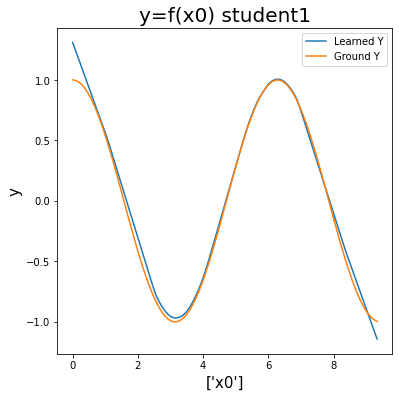

Epoch 1/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.9672 - mae: 0.6688
Epoch 2/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.8249 - mae: 0.6272
Epoch 3/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6129 - mae: 0.5582
Epoch 4/5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4455 - mae: 0.4956
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.2985 - mae: 0.4184


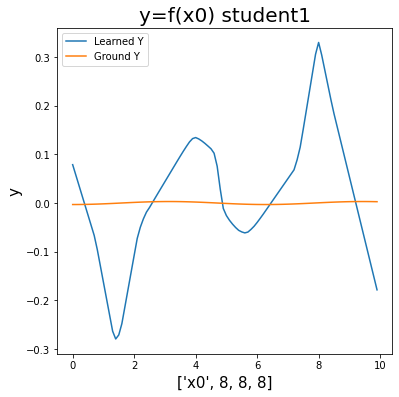

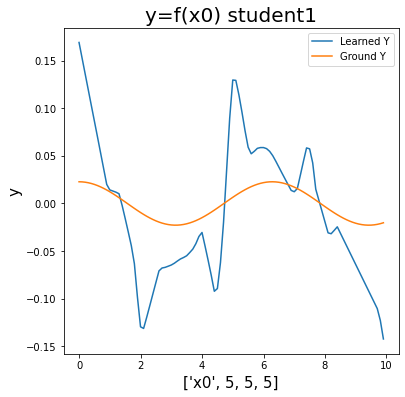

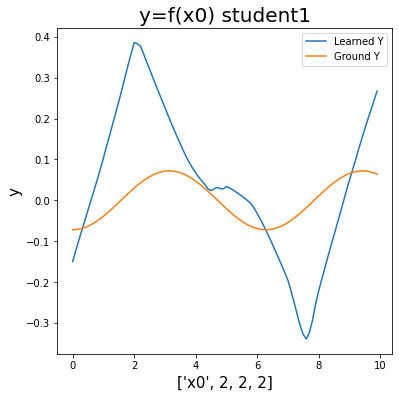

Epoch 1/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0032 - mae: 0.0216
Epoch 2/5
3000/3000 [==============================] - 5s 2ms/step - loss: 3.4025e-04 - mae: 0.0141
Epoch 3/5
3000/3000 [==============================] - 5s 2ms/step - loss: 2.7397e-04 - mae: 0.0131
Epoch 4/5
3000/3000 [==============================] - 5s 2ms/step - loss: 2.2876e-04 - mae: 0.0122
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 4.1782e-04 - mae: 0.0187


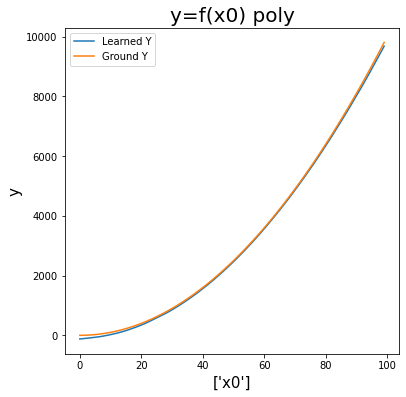

Regression stop watch runtime was 0:02:00.404639


In [ ]:
sw = StopWatch('Regression')
all(["function","student1"],["maxX",3*math.pi])
all(["function","student1"],["maxX",10],["nDimensions",4],["graph_x",[8,8,8,8]])
setAP(["function","student1"],["maxX",10],["nDimensions",4],["graph_x",[5,5,5,5]])
graph()
setAP(["function","student1"],["maxX",10],["nDimensions",4],["graph_x",[2,2,2,2]])
graph()
# all(["function","student1"], ['epochs', 15])
# all(['nDimensions',4], ['epochs', 20])
all()
sw.end()

## Classification

Classification stop watch start time: 2021-11-30 14:28:50.342913
Epoch 1/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0446 - accuracy: 0.9919
Epoch 2/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0125 - accuracy: 0.9968
Epoch 3/5
3000/3000 [==============================] - 7s 2ms/step - loss: 0.0096 - accuracy: 0.9973
Epoch 4/5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0082 - accuracy: 0.9974
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.9960


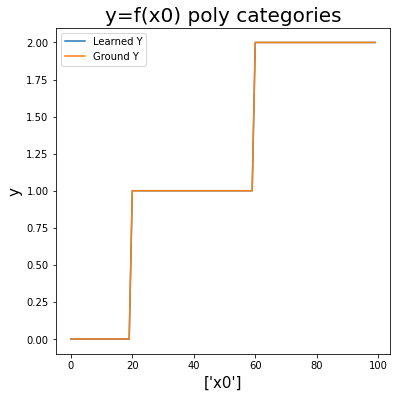

Classification stop watch runtime was 0:00:44.991777


In [ ]:
sw = StopWatch('Classification')
all(["categorize",[20**2, 60**2]])
sw.end()

## Plotting AP vs test_loss

Plotting AP vs loss stop watch start time: 2021-11-30 14:29:35.347085
Build for degree = 2
313/313 [==============================] - 1s 1ms/step - loss: 5.5836e-05 - mae: 0.0061


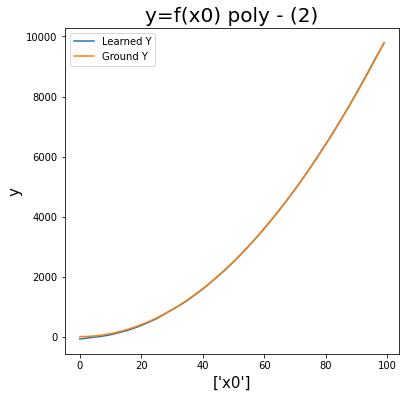

Build for degree = 3
313/313 [==============================] - 1s 1ms/step - loss: 1.9397e-05 - mae: 0.0030


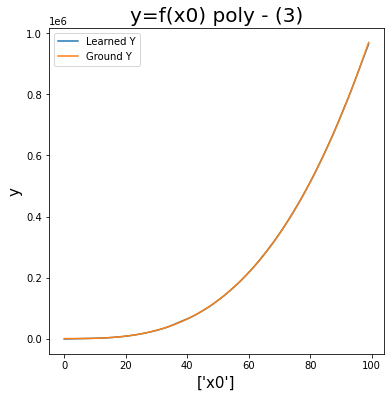

Build for degree = 5
313/313 [==============================] - 0s 1ms/step - loss: 3.5336e-04 - mae: 0.0174


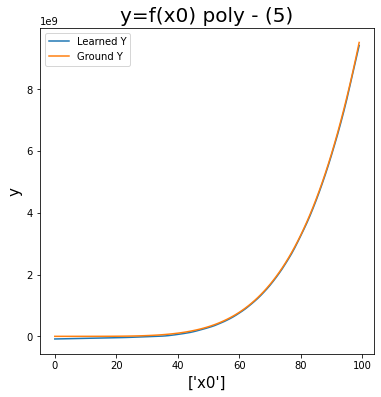

Build for degree = 10
313/313 [==============================] - 1s 1ms/step - loss: 0.0026 - mae: 0.0286


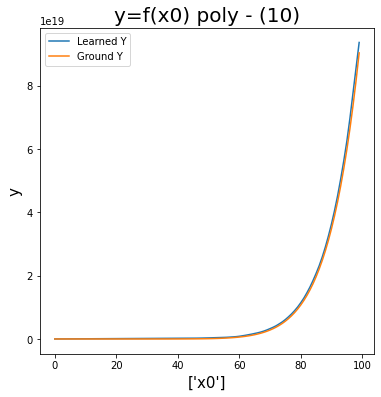

[2, 3, 5, 10] [5.58357351e-05 1.93974629e-05 3.53363430e-04 2.58393516e-03]


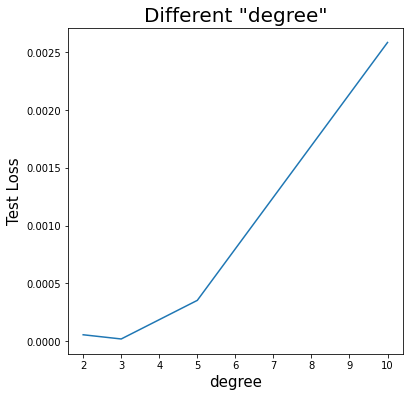

Plotting AP vs loss stop watch runtime was 0:00:33.923308


In [ ]:
sw = StopWatch('Plotting AP vs loss')
# plotAP(True,"degree",[2,3,5,10], [['epochs', 1], ['nDimensions', 4]])
plotAP(True,"degree",[2,3,5,10], [['epochs', 1], ])
# plotAP(True,"degree",[2,3,5,10],)
# plotAP(True,"degree",[2,3,5,10],[["function","exp"],["maxX",5]])
sw.end()

Plotting AP vs loss stop watch start time: 2021-11-30 14:35:07.393827
Build for activation = relu
Epoch 1/5
3000/3000 [==============================] - 5s 1ms/step - loss: 0.0767 - mae: 0.0869
Epoch 2/5
3000/3000 [==============================] - 4s 1ms/step - loss: 6.5298e-05 - mae: 0.0064
Epoch 3/5
3000/3000 [==============================] - 4s 1ms/step - loss: 5.5631e-05 - mae: 0.0060
Epoch 4/5
3000/3000 [==============================] - 4s 1ms/step - loss: 5.0004e-05 - mae: 0.0057
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 3.3023e-05 - mae: 0.0047


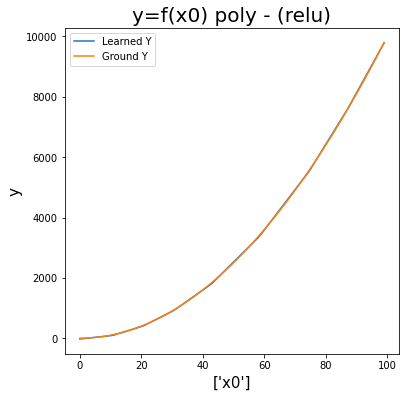

Build for activation = sigmoid
Epoch 1/5
3000/3000 [==============================] - 5s 1ms/step - loss: 0.1157 - mae: 0.1711
Epoch 2/5
3000/3000 [==============================] - 4s 1ms/step - loss: 3.8266e-04 - mae: 0.0162
Epoch 3/5
3000/3000 [==============================] - 4s 1ms/step - loss: 2.5265e-04 - mae: 0.0132
Epoch 4/5
3000/3000 [==============================] - 4s 1ms/step - loss: 1.9662e-04 - mae: 0.0116
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 5.8608e-05 - mae: 0.0057


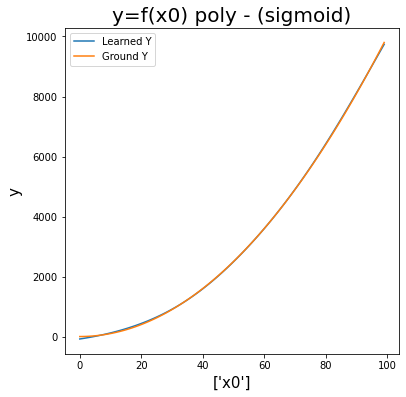

['relu', 'sigmoid'] [3.30230359e-05 5.86076203e-05]


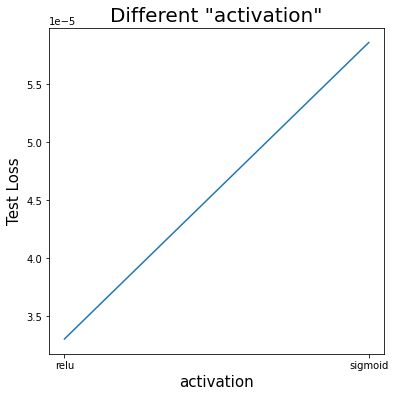

Plotting AP vs loss stop watch runtime was 0:01:09.295912


In [ ]:
sw = StopWatch('Plotting AP vs loss')
plotAP(True,"activation",["relu","sigmoid"], [['nHidden', 10], ])
sw.end()